# Matteo_Challenge1: ResNet Solution

## Import libraries

In [101]:
import os
import random
from datetime import datetime

import splitfolders

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from keras.models import load_model
from keras.layers import Dropout
from tensorflow.keras.applications.resnet_v2 import preprocess_input

from keras.layers import BatchNormalization
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [102]:
# Checking tensorflow version
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.10.0


In [103]:
# Setting seed for reproducibility
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Model Parameters and Classes Weights

In [104]:
labels = ['Species1',      # 0
          'Species2',      # 1
          'Species3',      # 2
          'Species4',      # 3
          'Species5',      # 4
          'Species6',      # 5
          'Species7',      # 6
          'Species8']      # 7

## Model Parameters and Metadata

In [105]:
# Input Parameters
img_w = 96
img_h = 96
input_shape = (96, 96, 3)
classes = 8

# Training Parameters
epochs = 90
batch_size = 64
reg_rate = 0.001

# Earlystopping Parameters
early_stopping = False
patience_epochs = 9

# Training and Validation Folders
dataset_dir = 'Dataset'
training_dir = os.path.join(dataset_dir, '../datasetWithoutTest/train')
validation_dir = os.path.join(dataset_dir, '../datasetWithoutTest/val')

In [106]:
def get_next_batch(generator):
    batch = next(generator)

    image = batch[0]
    target = batch[1]

    print("(Input) image shape:", image.shape)
    print("Target shape:",target.shape)

    # Visualize only the first sample
    image = image[0]
    target = target[0]
    target_idx = np.argmax(target)
    print()
    print("Categorical label:", target)
    print("Label:", target_idx)
    print("Class name:", labels[target_idx])
    fig = plt.figure(figsize=(6, 4))
    plt.imshow(np.uint8(image))

    return batch

## Data Augmentation

In [107]:
aug_train_data_gen = ImageDataGenerator(rotation_range=30,
                                         width_shift_range=10,
                                         height_shift_range=10,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         brightness_range=[0.2,1.2],
                                         fill_mode='nearest',
                                         preprocessing_function=preprocess_input)
                                         #rescale=1/255.

aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=labels,
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       seed=seed)

Found 5658 images belonging to 8 classes.


In [108]:
valid_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96, 96),
                                               color_mode='rgb',
                                               classes=labels,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               seed=seed)

Found 713 images belonging to 8 classes.


In [109]:
aug_train_data_gen =  ImageDataGenerator(rotation_range=30,
                                         width_shift_range=10,
                                         height_shift_range=10,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         brightness_range=[0.2,1.2],
                                         fill_mode='nearest',
                                         preprocessing_function=preprocess_input)
                                         #rescale=1/255.

## CNN Transfer Learning Model

In [110]:
supernet = tfk.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)

supernet.trainable = False

for i, layer in enumerate(supernet.layers[:50]):
  layer.trainable=False

for i, layer in enumerate(supernet.layers):
   print(i, layer.name, layer.trainable)


0 input_7 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [111]:
# Use the supernet as feature extractor
inputs = tfk.Input(shape=input_shape)

x = supernet(inputs)

glob_pooling = tfkl.GlobalAveragePooling2D(name='GlobalPooling')(x)

x = tfkl.Dense(
    512,
    kernel_initializer = tfk.initializers.GlorotUniform(seed)
)(glob_pooling)

leaky_relu_layer = tfkl.LeakyReLU()(x)

x = tfkl.BatchNormalization()(x)

x = tfkl.Dropout(0.3, seed=seed)(leaky_relu_layer)

outputs = tfkl.Dense(
    8,
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed),
)(x)


# Connect input and output through the Model class
resnet_Model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
resnet_Model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-3), metrics=['accuracy'])

resnet_Model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 resnet50v2 (Functional)     (None, 3, 3, 2048)        23564800  
                                                                 
 GlobalPooling (GlobalAverag  (None, 2048)             0         
 ePooling2D)                                                     
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                             

## Utility Callbacks

In [112]:
# Utility function to create folders and callbacks for training
def create_folders_and_callbacks(model_name) :
    exps_dir = os.path.join('data_augmentation_experiments')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)

    now = datetime.now().strftime('%b%d_%H-%M-%S')

    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)

    callbacks = []

    # Model checkpoint ---------------------------------------------------
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp'), # filepath is where I want to save the model
                                                     save_weights_only=False, # save only the weights ora all the model
                                                     save_best_only=True) # if True saves only the results of the best epoch

    callbacks.append(ckpt_callback)

    # Visualize Learning on Tensorboard ----------------------------------
    tb_dir = os.path.join(exp_dir, 'tb_logs') # logs where we save the events, where the tensorboard will read the logs
    if not os.path.exists(tb_dir):
        os.makedirs(tb_dir)

    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                              profile_batch=0,
                                              histogram_freq=1)
    callbacks.append(tb_callback)

    # Early Stopping -----------------------------------------------------
    if early_stopping:
        es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience_epochs, restore_best_weights=True)
        callbacks.append(es_callback)

    return callbacks

## Training

In [113]:
# Create folders and callbacks and fit
callbacks = create_folders_and_callbacks(model_name='ResNet_CNN_FT1')

# Train the model
history = resnet_Model.fit(
    x = aug_train_gen,
    epochs = 90,
    validation_data = valid_gen,
    callbacks = callbacks,
).history

Epoch 1/90


2022-11-15 10:46:16.070472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


89/89 [==============================] - ETA: 0s - loss: 1.8375 - accuracy: 0.4123

2022-11-15 10:46:27.855502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


89/89 [==============================] - 35s 367ms/step - loss: 1.8375 - accuracy: 0.4123 - val_loss: 1.5283 - val_accuracy: 0.4348
Epoch 2/90
89/89 [==============================] - ETA: 0s - loss: 1.4699 - accuracy: 0.4823

INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


89/89 [==============================] - 30s 340ms/step - loss: 1.4699 - accuracy: 0.4823 - val_loss: 1.4358 - val_accuracy: 0.4783
Epoch 3/90
89/89 [==============================] - ETA: 0s - loss: 1.3685 - accuracy: 0.5115

INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


89/89 [==============================] - 30s 333ms/step - loss: 1.3685 - accuracy: 0.5115 - val_loss: 1.3899 - val_accuracy: 0.5007
Epoch 4/90
89/89 [==============================] - 13s 139ms/step - loss: 1.3186 - accuracy: 0.5293 - val_loss: 1.4415 - val_accuracy: 0.4937
Epoch 5/90
89/89 [==============================] - ETA: 0s - loss: 1.3052 - accuracy: 0.5263

INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


89/89 [==============================] - 30s 340ms/step - loss: 1.3052 - accuracy: 0.5263 - val_loss: 1.3626 - val_accuracy: 0.5231
Epoch 6/90
89/89 [==============================] - ETA: 0s - loss: 1.2838 - accuracy: 0.5346

INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


89/89 [==============================] - 30s 339ms/step - loss: 1.2838 - accuracy: 0.5346 - val_loss: 1.3526 - val_accuracy: 0.5386
Epoch 7/90
89/89 [==============================] - ETA: 0s - loss: 1.2661 - accuracy: 0.5353

INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


89/89 [==============================] - 32s 355ms/step - loss: 1.2661 - accuracy: 0.5353 - val_loss: 1.3483 - val_accuracy: 0.5372
Epoch 8/90
89/89 [==============================] - ETA: 0s - loss: 1.2461 - accuracy: 0.5391

INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


89/89 [==============================] - 30s 341ms/step - loss: 1.2461 - accuracy: 0.5391 - val_loss: 1.2912 - val_accuracy: 0.5147
Epoch 9/90
89/89 [==============================] - ETA: 0s - loss: 1.2342 - accuracy: 0.5449

INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


89/89 [==============================] - 30s 335ms/step - loss: 1.2342 - accuracy: 0.5449 - val_loss: 1.2759 - val_accuracy: 0.5344
Epoch 10/90
89/89 [==============================] - 13s 141ms/step - loss: 1.2141 - accuracy: 0.5520 - val_loss: 1.3344 - val_accuracy: 0.5245
Epoch 11/90
89/89 [==============================] - 12s 139ms/step - loss: 1.1944 - accuracy: 0.5638 - val_loss: 1.2937 - val_accuracy: 0.5316
Epoch 12/90
89/89 [==============================] - 12s 136ms/step - loss: 1.1987 - accuracy: 0.5716 - val_loss: 1.3243 - val_accuracy: 0.5147
Epoch 13/90
89/89 [==============================] - 12s 134ms/step - loss: 1.1941 - accuracy: 0.5619 - val_loss: 1.2910 - val_accuracy: 0.5316
Epoch 14/90
89/89 [==============================] - 12s 131ms/step - loss: 1.1907 - accuracy: 0.5689 - val_loss: 1.2834 - val_accuracy: 0.5344
Epoch 15/90
89/89 [==============================] - 12s 132ms/step - loss: 1.1756 - accuracy: 0.5626 - val_loss: 1.2835 - val_accuracy: 0.5288
Epoc

INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


89/89 [==============================] - 31s 354ms/step - loss: 1.1600 - accuracy: 0.5732 - val_loss: 1.2707 - val_accuracy: 0.5372
Epoch 20/90
89/89 [==============================] - ETA: 0s - loss: 1.1629 - accuracy: 0.5725

INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


89/89 [==============================] - 31s 353ms/step - loss: 1.1629 - accuracy: 0.5725 - val_loss: 1.2643 - val_accuracy: 0.5470
Epoch 21/90
89/89 [==============================] - ETA: 0s - loss: 1.1398 - accuracy: 0.5832

INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


89/89 [==============================] - 30s 338ms/step - loss: 1.1398 - accuracy: 0.5832 - val_loss: 1.2568 - val_accuracy: 0.5344
Epoch 22/90
89/89 [==============================] - 12s 137ms/step - loss: 1.1406 - accuracy: 0.5824 - val_loss: 1.2643 - val_accuracy: 0.5554
Epoch 23/90
89/89 [==============================] - ETA: 0s - loss: 1.1307 - accuracy: 0.5806

INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


89/89 [==============================] - 30s 335ms/step - loss: 1.1307 - accuracy: 0.5806 - val_loss: 1.2541 - val_accuracy: 0.5330
Epoch 24/90
89/89 [==============================] - 13s 139ms/step - loss: 1.1090 - accuracy: 0.5882 - val_loss: 1.2681 - val_accuracy: 0.5330
Epoch 25/90
89/89 [==============================] - ETA: 0s - loss: 1.1346 - accuracy: 0.5799

INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


89/89 [==============================] - 29s 330ms/step - loss: 1.1346 - accuracy: 0.5799 - val_loss: 1.2447 - val_accuracy: 0.5442
Epoch 26/90
89/89 [==============================] - 13s 140ms/step - loss: 1.1447 - accuracy: 0.5854 - val_loss: 1.2477 - val_accuracy: 0.5442
Epoch 27/90
89/89 [==============================] - 12s 136ms/step - loss: 1.1322 - accuracy: 0.5898 - val_loss: 1.2458 - val_accuracy: 0.5554
Epoch 28/90
89/89 [==============================] - 12s 138ms/step - loss: 1.1249 - accuracy: 0.5893 - val_loss: 1.2868 - val_accuracy: 0.5217
Epoch 29/90
89/89 [==============================] - 12s 134ms/step - loss: 1.1477 - accuracy: 0.5725 - val_loss: 1.2603 - val_accuracy: 0.5442
Epoch 30/90
89/89 [==============================] - ETA: 0s - loss: 1.1420 - accuracy: 0.5786

INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


89/89 [==============================] - 29s 332ms/step - loss: 1.1420 - accuracy: 0.5786 - val_loss: 1.2439 - val_accuracy: 0.5358
Epoch 31/90
89/89 [==============================] - ETA: 0s - loss: 1.1105 - accuracy: 0.5919

INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


89/89 [==============================] - 30s 333ms/step - loss: 1.1105 - accuracy: 0.5919 - val_loss: 1.2366 - val_accuracy: 0.5414
Epoch 32/90
89/89 [==============================] - 12s 138ms/step - loss: 1.1184 - accuracy: 0.5986 - val_loss: 1.2448 - val_accuracy: 0.5456
Epoch 33/90
89/89 [==============================] - ETA: 0s - loss: 1.1118 - accuracy: 0.5878

INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


89/89 [==============================] - 30s 335ms/step - loss: 1.1118 - accuracy: 0.5878 - val_loss: 1.2325 - val_accuracy: 0.5414
Epoch 34/90
89/89 [==============================] - 12s 138ms/step - loss: 1.1090 - accuracy: 0.5916 - val_loss: 1.2731 - val_accuracy: 0.5428
Epoch 35/90
89/89 [==============================] - ETA: 0s - loss: 1.1283 - accuracy: 0.5878

INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


89/89 [==============================] - 30s 339ms/step - loss: 1.1283 - accuracy: 0.5878 - val_loss: 1.2301 - val_accuracy: 0.5428
Epoch 36/90
89/89 [==============================] - 13s 140ms/step - loss: 1.1102 - accuracy: 0.5914 - val_loss: 1.2629 - val_accuracy: 0.5428
Epoch 37/90
89/89 [==============================] - 12s 137ms/step - loss: 1.0982 - accuracy: 0.5974 - val_loss: 1.2499 - val_accuracy: 0.5358
Epoch 38/90
89/89 [==============================] - 12s 138ms/step - loss: 1.1153 - accuracy: 0.5903 - val_loss: 1.2784 - val_accuracy: 0.5428
Epoch 39/90
89/89 [==============================] - 12s 134ms/step - loss: 1.1105 - accuracy: 0.5924 - val_loss: 1.2706 - val_accuracy: 0.5470
Epoch 40/90
89/89 [==============================] - 12s 132ms/step - loss: 1.1139 - accuracy: 0.5829 - val_loss: 1.2375 - val_accuracy: 0.5428
Epoch 41/90
89/89 [==============================] - ETA: 0s - loss: 1.0969 - accuracy: 0.5979

INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


89/89 [==============================] - 29s 325ms/step - loss: 1.0969 - accuracy: 0.5979 - val_loss: 1.2267 - val_accuracy: 0.5568
Epoch 42/90
89/89 [==============================] - 13s 140ms/step - loss: 1.1140 - accuracy: 0.5914 - val_loss: 1.2482 - val_accuracy: 0.5526
Epoch 43/90
89/89 [==============================] - 12s 138ms/step - loss: 1.0866 - accuracy: 0.6048 - val_loss: 1.2444 - val_accuracy: 0.5400
Epoch 44/90
89/89 [==============================] - ETA: 0s - loss: 1.1187 - accuracy: 0.5935

INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/ResNet_CNN_FT1_Nov15_10-46-14/ckpts/cp/assets


89/89 [==============================] - 31s 351ms/step - loss: 1.1187 - accuracy: 0.5935 - val_loss: 1.2088 - val_accuracy: 0.5666
Epoch 45/90
89/89 [==============================] - 13s 146ms/step - loss: 1.1009 - accuracy: 0.5938 - val_loss: 1.2148 - val_accuracy: 0.5484
Epoch 46/90
89/89 [==============================] - 13s 148ms/step - loss: 1.0871 - accuracy: 0.5965 - val_loss: 1.2430 - val_accuracy: 0.5470
Epoch 47/90
87/89 [============================>.] - ETA: 0s - loss: 1.0860 - accuracy: 0.6045

KeyboardInterrupt: 

In [95]:
# Saving the last epoch of the train
save_dir = os.path.join('ResNet_CNN')
resnet_Model.save(save_dir)

INFO:tensorflow:Assets written to: ResNet_CNN/assets


INFO:tensorflow:Assets written to: ResNet_CNN/assets


## Graphs Visualization

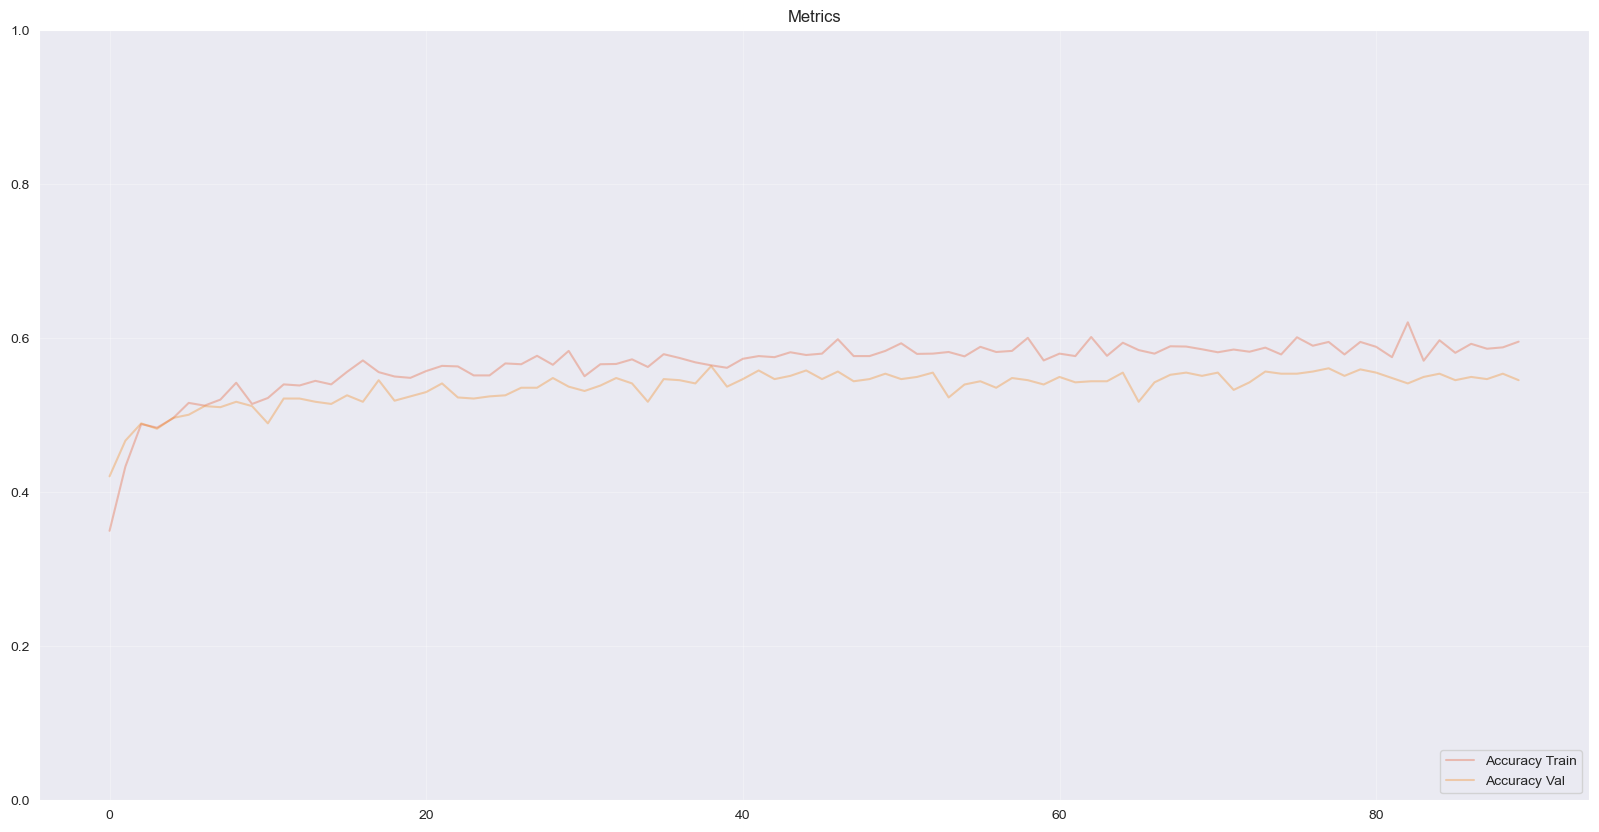

In [96]:
# All the metrics : Accuracy, Precision and Recall
ALPHA = 0.3

plt.figure(figsize=(20,10))

plt.plot(history['accuracy'], label='Accuracy Train', alpha=ALPHA, color='#E64A19')
plt.plot(history['val_accuracy'], label='Accuracy Val', alpha=ALPHA, color='#F57C00')

plt.ylim(0, 1)
plt.title('Metrics')
plt.legend(loc='lower right')
plt.grid(alpha=.3)
plt.show()

## Confusion Matrix

(Input) image shape: (64, 96, 96, 3)
Target shape: (64, 8)

Categorical label: [0. 0. 1. 0. 0. 0. 0. 0.]
Label: 2
Class name: Species3
2/2 [==============================] - 0s 52ms/step


<AxesSubplot:>

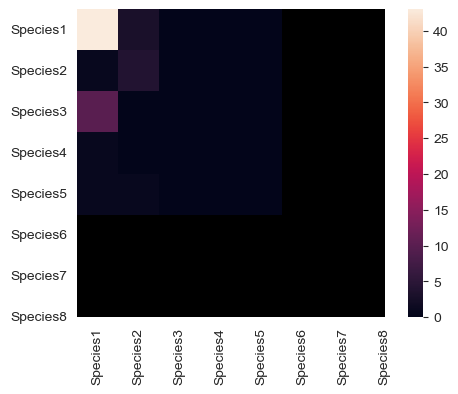

In [100]:
x,y=get_next_batch(valid_gen)
predictions=resnet_Model.predict(x)
predictions.shape
cm = confusion_matrix(np.argmax(y, axis=-1), np.argmax(predictions, axis=-1))
sns.heatmap(cm.T,xticklabels=list(labels), yticklabels=list(labels))